# Mauve and coherence metrics exploration

Notebook for doing some EDA on metrics

In [1]:
INPUT_DIR = "/cmlscratch/manlis/test/watermarking-root/input"
OUTPUT_DIR = "/cmlscratch/manlis/test/watermarking-root/output"

In [2]:
# Basic imports
import os

from tqdm import tqdm
from statistics import mean

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import cmasher as cmr

In [3]:
from datasets import load_from_disk

/cmlscratch/manlis/anaconda3/envs/watermarking-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the processed dataset/frame

In [4]:
# save_name = "analysis_ds_1-21_greedy_redo" 
# save_name = "analysis_ds_1-21_greedy_redo_truncated_sanity_check"
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_truncated" 
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_0-5_truncated" # in figure (not 100% sure this is correct, check)

# save_name = "analysis_ds_1-20_more_attack" # in figure

save_name = "analysis_ds_1-19_realnews_1-3_v1" # in figure
# save_name = "analysis_ds_1-23_en_1-3"
# save_name = "analysis_ds_1-23_pile_1-3"

save_dir = f"{INPUT_DIR}/processed_datasets/{save_name}"

In [5]:
raw_data = load_from_disk(save_dir)

#### convert to pandas df

In [6]:
df = raw_data.to_pandas()

In [7]:
print(f"Orig number of rows: {len(df)}")
df.tail()

Orig number of rows: 66194


,idx,truncated_input,baseline_completion,orig_sample_length,prompt_length,real_completion_length,no_bl_gen_time,w_bl_gen_time,spike_entropies,no_bl_output,...,w_bl_num_toks_gend_eq_0,w_bl_whitelist_fraction,w_bl_blacklist_fraction,w_bl_hit_list,avg_spike_entropy,w_bl_exp_num_wl_tokens,w_bl_var_num_wl_tokens,exp_wl_coef,w_bl_exp_whitelist_fraction,w_bl_var_whitelist_fraction
66189,1629,"The cast of the 90s TV show, Hip Hip Hurray, j...",ed the picture post as: Nostalgia#at its best....,319,119,200,2.813786,0.767504,"[[0.10299381613731384, 0.3138567805290222, 0.2...","ed the post, ""No cast ever.... (sic).""\nHere's...",...,False,1.0,0.0,"[False, False, False, False, False, False, Fal...",0.505296,26.275373,12.998542,1.0,0.505296,0.249972
66190,1631,"Seated left to right are Viktor Averin, Sergei...","""arguably the mightiest organised crime group...",1130,930,200,3.019276,1.591323,"[[0.39239728450775146, 0.6695157289505005, 0.3...","""the largest and most powerful mafia organisa...",...,False,1.0,0.0,"[False, False, False, False, False, False, Fal...",0.531480,49.959114,23.406847,1.0,0.531480,0.249009
66191,1632,Does Age Predict Technology Adoption?\nA commo...,"than bound paper, ink and glue to younger or ...",886,686,200,1.283562,3.061106,"[[0.11953060328960419, 0.625767171382904, 0.38...",than that of a traditional print copy. In som...,...,False,1.0,0.0,"[False, False, False, False, False, False, Fal...",0.213594,42.718895,33.594375,1.0,0.213594,0.167972
66192,1633,CES attendees inspect Intel UltraBooks at the ...,appease the growing number of employees who a...,1219,1019,200,3.045814,0.448559,"[[0.9118322134017944, 0.8717396259307861, 0.69...",keep a laptop in the office and another in th...,...,False,1.0,0.0,"[False, False, False, False, False, False, Fal...",0.622416,8.713821,3.290201,1.0,0.622416,0.235014
66193,1635,"Washington, Mar. 9 - Israel is the only safe p...","a wave of church destructions and in Iran, co...",523,323,200,2.861036,2.960533,"[[0.693812370300293, 0.6877695322036743, 0.826...","a surge in violence against Christians, espec...",...,False,1.0,0.0,"[False, False, False, False, False, False, Fal...",0.243750,48.749969,36.867172,1.0,0.243750,0.184336


In [8]:
df.columns

Index(['idx', 'truncated_input', 'baseline_completion', 'orig_sample_length',
       'prompt_length', 'real_completion_length', 'no_bl_gen_time',
       'w_bl_gen_time', 'spike_entropies', 'no_bl_output', 'w_bl_output',
       'no_bl_num_tokens_generated', 'w_bl_num_tokens_generated',
       'no_bl_sec_per_tok', 'no_bl_tok_per_sec', 'w_bl_sec_per_tok',
       'w_bl_tok_per_sec', 'baseline_loss', 'baseline_ppl', 'no_bl_loss',
       'no_bl_ppl', 'w_bl_loss', 'w_bl_ppl', 'model_name', 'dataset_name',
       'dataset_config_name', 'shuffle_dataset', 'shuffle_seed',
       'shuffle_buffer_size', 'max_new_tokens', 'min_prompt_tokens',
       'limit_indices', 'input_truncation_strategy',
       'input_filtering_strategy', 'output_filtering_strategy', 'initial_seed',
       'dynamic_seed', 'bl_proportion', 'bl_logit_bias', 'bl_type',
       'num_beams', 'no_repeat_ngram_size', 'early_stopping',
       'oracle_model_name', 'no_wandb', 'wandb_project', 'wandb_entity',
       'run_name', 'output

## mega filter block

In [9]:
# drop retok_problematic_rows
retok_problematic_rows = df[(df['w_bl_whitelist_fraction'] != -1.0) & (df['w_bl_whitelist_fraction'] != 1.0) & (df['bl_type'] == 'hard')]
print(f"Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: {len(retok_problematic_rows)} out of {len(df[df['bl_type'] == 'hard'])}")

# drop special rows marked as -1.0
orig_len = len(df)

# df['no_bl_whitelist_fraction'].mask(df['no_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)
# df['w_bl_whitelist_fraction'].mask(df['w_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)

df = df[df["no_bl_whitelist_fraction"] != -1.0]
df = df[df["w_bl_whitelist_fraction"] != -1.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# drop too few tokesn rows

orig_len = len(df)
# df = df[df["no_bl_ppl"].isna()]
# df = df[df["w_bl_ppl"].isna()]
df = df[~(df["no_bl_ppl"].isna() | df["w_bl_ppl"].isna())]
print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# drop huge biases
orig_len = len(df)

df = df[df["bl_logit_bias"] <= 100.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

orig_len = len(df)

# df = df[df["bl_hparams"].apply(lambda tup: (tup[0] == False and tup[2] != 1) or (tup[0] == True and tup[2] == 1) or (tup[0] == False))]
df = df[((df["use_sampling"]==True) & (df["num_beams"] == 1)) | (df["use_sampling"]==False)]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

# correct sampling temp
df.loc[df["use_sampling"]==False,"sampling_temp"] = df.loc[df["use_sampling"]==False,"sampling_temp"].fillna(0.0)
df.loc[df["use_sampling"]==True,"sampling_temp"] = df.loc[df["use_sampling"]==True,"sampling_temp"].fillna(1.0)

# set to inf for hard blacklist
df.loc[df["bl_type"]=="hard","bl_logit_bias"] = np.inf
# df.loc[df["bl_type"]=="hard","bl_logit_bias"] = 10000 # crosscheck with whats hardcoded in the bl processor

# rename some stuff
df["delta"] = df["bl_logit_bias"].values
df["gamma"] = 1 - df["bl_proportion"].values
df["gamma"] = df["gamma"].round(3)

df["no_bl_act_num_wl_tokens"] = np.round(df["no_bl_whitelist_fraction"].values*df["no_bl_num_tokens_generated"],1) # round to 1 for sanity
df["w_bl_act_num_wl_tokens"] = np.round(df["w_bl_whitelist_fraction"].values*df["w_bl_num_tokens_generated"],1) # round to 1 for sanity

df["w_bl_std_num_wl_tokens"] = np.sqrt(df["w_bl_var_num_wl_tokens"].values)

if "real_completion_length":
    df["baseline_num_tokens_generated"] = df["real_completion_length"].values

if "actual_attacked_ratio" in df.columns:
    df["actual_attacked_fraction"] = df["actual_attacked_ratio"].values*df["replace_ratio"].values

if "meta" in df.columns:
    df["pile_set_name"] = df["meta"].apply(lambda dict: dict["pile_set_name"])

df["baseline_hit_list_length"] = df["baseline_hit_list"].apply(len)
df["no_bl_hit_list_length"] = df["no_bl_hit_list"].apply(len)
df["w_bl_hit_list_length"] = df["w_bl_hit_list"].apply(len)


# for pile outlier filtering
df["w_bl_space_count"] = df["w_bl_output"].apply(lambda string: string.count(" "))
df["no_bl_space_count"] = df["no_bl_output"].apply(lambda string: string.count(" "))
df["baseline_space_count"] = df["baseline_completion"].apply(lambda string: string.count(" "))

df["w_bl_space_frac"] = df["w_bl_space_count"].values / df["w_bl_hit_list_length"]
df["no_bl_space_frac"] = df["no_bl_space_count"].values / df["no_bl_hit_list_length"]
df["baseline_space_frac"] = df["baseline_space_count"].values / df["baseline_hit_list_length"]


# Final length filtering 

orig_len = len(df)

# # main filters
# # df = df[(df["real_completion_length"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["gamma"] == 0.1) | (df["gamma"] == 0.25) | (df["gamma"] == 0.5)]
# df = df[(df["delta"] == 1.0) | (df["delta"] == 2.0) | (df["delta"] == 10.0)]
# df = df[(df["use_sampling"] == True)]
# df = df[(df["bl_type"] == "soft")]

# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)] # now also applies to the truncated version
# df = df[(df["no_bl_num_tokens_generated"] >= 500) & (df["w_bl_num_tokens_generated"] >= 500)] # all gas noop

# # # attack specific
# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["replace_ratio"] <= 0.7)]

# # NOTE pile only
# df = df[df["w_bl_space_frac"] <= 0.9]
# df = df[df["no_bl_space_frac"] <= 0.9]
# df = df[df["pile_set_name"] != "Github"]

upper_T = 205
lower_T = 195
df = df[(df["baseline_hit_list_length"] >= lower_T) & (df["no_bl_hit_list_length"] >= lower_T) & (df["w_bl_hit_list_length"] >= lower_T)] # now also applies to the truncated version
df = df[(df["baseline_hit_list_length"] <= upper_T) & (df["no_bl_hit_list_length"] <= upper_T) & (df["w_bl_hit_list_length"] <= upper_T)] # now also applies to the truncated version


print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: 0 out of 0
Dropped 721 rows, new len 65473
Dropped 0 rows, new len 65473
Dropped 0 rows, new len 65473
Dropped 0 rows, new len 65473
Dropped 37334 rows, new len 28139


# Add z-scores

In [10]:
from math import sqrt
import scipy.stats
def compute_z_score(observed_wl_frac, T, gamma):
    numer = observed_wl_frac - gamma
    denom = sqrt(gamma*(1-gamma)/T)
    z = numer/denom
    return z

def compute_wl_for_z(z, T, gamma):
    denom = sqrt(gamma*(1-gamma)/T)
    numer = ((z*denom)+gamma)*T
    return numer

def compute_p_value(z):
    p_value = scipy.stats.norm.sf(z)
    return p_value

df["baseline_z_score"] = df[["baseline_whitelist_fraction", "baseline_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
df["no_bl_z_score"] = df[["no_bl_whitelist_fraction", "no_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
df["w_bl_z_score"] = df[["w_bl_whitelist_fraction", "w_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

if "w_bl_attacked_whitelist_fraction" in df.columns:
    df["w_bl_attacked_z_score"] = df[["w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

In [11]:
# if attacked in df
if "w_bl_attacked_whitelist_fraction" in df.columns:
    df["w_bl_attacked_act_num_wl_tokens"] = np.round(df["w_bl_attacked_whitelist_fraction"].values*df["w_bl_attacked_num_tokens_generated"],1) # round to 1 for sanity

    df["w_bl_attacked_z_score"] = df[["w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

    df[["bl_proportion","w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated","w_bl_attacked_act_num_wl_tokens", "w_bl_attacked_z_score"]]

# Groupby (decide which hyperparameters to groups the rows by)

In [12]:
if "w_bl_attacked_whitelist_fraction" in df.columns: 
    groupby_fields = ['use_sampling','num_beams','gamma','delta', 'replace_ratio'] # attack grouping
else:
    groupby_fields = ['use_sampling','num_beams','delta','gamma'] # regular grouping

In [13]:
grouped_df = df.groupby(groupby_fields)

In [14]:
print(f"Number of rows after filtering: {len(df)}")
print(f"Number of groups: {len(grouped_df)}")

Number of rows after filtering: 28139
Number of groups: 56


In [15]:
grouped_df["w_bl_z_score"].describe()

count       mean       std        min  \
use_sampling num_beams delta gamma                                          
False        1         0.1   0.50   497.0   0.775204  2.517472  -6.788225   
                       0.5   0.50   496.0   2.905542  2.515852  -5.798276   
                       1.0   0.50   497.0   5.407189  2.606488  -3.394113   
                       2.0   0.50   495.0   8.785251  2.422845  -1.555635   
                       5.0   0.50   495.0  12.431525  1.582604   0.848528   
                       10.0  0.50   491.0  13.988974  0.397100  10.748023   
                       50.0  0.50   488.0  14.076854  0.333189  10.748023   
             4         0.1   0.50   500.0   1.225231  1.931048  -5.091169   
                       0.5   0.50   504.0   4.121540  1.785928  -2.545584   
                       1.0   0.50   506.0   7.248399  1.827018   1.838478   
                       2.0   0.50   504.0  11.145401  1.429662   3.252691   
                       5.0   0.50   507.0  13.921719  0.441143   8.909545   
                       10.0  0.50   505.0  14.112293  0.129659  12.586501   
                       50.0  0.50   508.0  14.117756  0.123950  12.586501   
             8         0.1   0.50   501.0   1.194271  1.867354  -5.232590   
                       0.5   0.50   503.0   4.403488  1.913617  -2.687006   
                       1.0   0.50   501.0   7.862284  1.909225   1.414214   
                       2.0   0.50   502.0  11.743655  1.245523   3.959798   
                       5.0   0.50   498.0  14.048135  0.184397  12.162237   
                       10.0  0.50   500.0  14.118455  0.145913  11.879394   
                       50.0  0.50   502.0  14.120095  0.144250  11.879394   
True         1         0.1   0.10   507.0   0.794085  1.477187  -4.477159   
                             0.25   510.0   0.174547  1.231675  -3.265986   
                             0.50   504.0   0.785959  1.331575  -3.676955   
                             0.75   506.0   0.769141  1.216546  -6.858571   
                             0.90   505.0   0.426764  1.078141  -3.064129   
                       0.5   0.10   502.0   2.190078  1.583207  -2.357023   
                             0.25   503.0   2.067980  1.321680  -1.796292   
                             0.50   503.0   2.769410  1.401529 -12.020815   
                             0.75   504.0   2.258562  1.120684  -3.265986   
                             0.90   515.0   1.352280  1.087089  -4.949747   
                       1.0   0.10   506.0   4.505423  1.912686  -3.535534   
                             0.25   506.0   4.788918  1.523620  -0.653197   
                             0.50   506.0   4.899046  1.496086  -1.272792   
                             0.75   504.0   3.794776  1.005397  -0.326599   
                             0.90   501.0   2.187248  0.995490  -3.771236   
                       2.0   0.10   507.0  11.266219  2.745536   1.649916   
                             0.25   505.0  10.669313  2.263002  -1.143095   
                             0.50   507.0   8.520831  1.498280  -1.131371   
                             0.75   505.0   5.494584  1.076413  -1.469694   
                             0.90   505.0   3.283954  0.826203  -2.357023   
                       5.0   0.10   501.0  33.031715  4.074784  20.270394   
                             0.25   503.0  21.247814  1.998682   4.536092   
                             0.50   504.0  12.566653  1.241437   2.828427   
                             0.75   502.0   7.432600  0.752119   0.163299   
                             0.90   501.0   4.275912  0.514057  -0.235702   
                       10.0  0.10   490.0  41.556418  1.800056  19.327585   
                             0.25   499.0  24.166544  0.884251   7.838367   
                             0.50   507.0  13.973804  0.251381  12.162237   
                             0.75   504.0   8.079043  0.183141   6.531973   
                             0.9

### new metrics

In [16]:
# coherence 
import sys
sys.path.insert(0, "..")
from metrics.coherence import get_coherence_score

group = (True, 1, 2.0, 0.5)
# group = (False, 1, 2.0, 0.5
group_df = grouped_df.get_group(group)

prefix_text = group_df["truncated_input"].values.tolist()

baseline_completion = group_df["baseline_completion"].values.tolist()
w_bl_output = group_df["w_bl_output"].values.tolist()
no_bl_output = group_df["no_bl_output"].values.tolist()

coherence_ref = get_coherence_score(prefix_text, baseline_completion)
coherence_w_bl = get_coherence_score(prefix_text, w_bl_output)
coherence_no_bl = get_coherence_score(prefix_text, no_bl_output)

print(f"cohenrence score: baseline {coherence_ref}, w/ bl {coherence_w_bl}, no bl {coherence_no_bl}")


507 507


100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


cohenrence score: baseline 0.6112307937892937, w/ bl 0.6077465531388684, no bl 0.6196773611817369


In [17]:
# MAUVE (https://github.com/XiangLi1999/ContrastiveDecoding)
import sys
sys.path.insert(0, "..")
from metrics.mauve import get_mauve_score

group = (True, 1, 2.0, 0.5)
# group = (False, 1, 2.0, 0.5
group_df = grouped_df.get_group(group)

## first measure betwee baseline and output w/ watermark
p_text = group_df["baseline_completion"].values.tolist()
q_text_w_bl = group_df["w_bl_output"].values.tolist()
q_text_no_bl = group_df["no_bl_output"].values.tolist()

mauve_w_bl = get_mauve_score(p_text, q_text_w_bl, max_len=128)
mauve_no_bl = get_mauve_score(p_text, q_text_no_bl, max_len=128)

print(mauve_w_bl, mauve_no_bl)



03/31/2023 14:25:23 - INFO - faiss.loader -   Loading faiss with AVX2 support.
03/31/2023 14:25:23 - INFO - faiss.loader -   Successfully loaded faiss with AVX2 support.


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 119.58it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 124.32it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


0.9199462059182815 0.8585088981213014


In [20]:
# make MAUVE plot
# Sampling
group_list =(
    (True, 1, 2.0, 0.9),
    (True, 1, 2.0, 0.75),
    (True, 1, 2.0, 0.5),
    (True, 1, 2.0, 0.25),
    (True, 1, 2.0, 0.1),

    (True, 1, 0.1, 0.5),
    (True, 1, 0.5, 0.5),
    (True, 1, 1.0, 0.5),
    (True, 1, 2.0, 0.5),
    (True, 1, 5.0, 0.5),
)

sampling, beams, gammas, deltas = [], [], [], []
# baseline_mauve = []
no_watermark_mauve = []
watermark_mauve = []

for idx, group in enumerate(group_list):
    group_df = grouped_df.get_group(group)

    sampling.append(group[0])
    beams.append(group[1])
    deltas.append(group[2])
    gammas.append(group[3])
    ## get mauve scores
    p_text = group_df["baseline_completion"].values.tolist()
    q_text_w_bl = group_df["w_bl_output"].values.tolist()
    q_text_no_bl = group_df["no_bl_output"].values.tolist()

    watermark_mauve.append(get_mauve_score(p_text, q_text_w_bl, max_len=128))
    no_watermark_mauve.append(get_mauve_score(p_text, q_text_no_bl, max_len=128))

viz_df = pd.DataFrame()


viz_df["sampling"] = sampling
viz_df["beams"] = beams
viz_df["gammas"] = gammas
viz_df["deltas"] = deltas

viz_df['no_watermark_mauve'] = no_watermark_mauve
viz_df['watermark_mauve'] = watermark_mauve

viz_df

initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 123.65it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 123.38it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 122.60it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 121.59it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 121.60it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 122.27it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 124.41it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 505, q_text: 505
remaining p_text: 505, q_text: 505


Featurizing q: 100%|██████████| 505/505 [00:04<00:00, 123.34it/s]
WARNING clustering 1010 points to 50 centroids: please provide at least 1950 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 124.39it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 122.24it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 122.39it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 121.99it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 503, q_text: 503
remaining p_text: 503, q_text: 503


Featurizing q: 100%|██████████| 503/503 [00:04<00:00, 123.80it/s]
WARNING clustering 1006 points to 50 centroids: please provide at least 1950 training points


initial p_text: 503, q_text: 503
remaining p_text: 503, q_text: 503


Featurizing q: 100%|██████████| 503/503 [00:04<00:00, 124.51it/s]
WARNING clustering 1006 points to 50 centroids: please provide at least 1950 training points


initial p_text: 506, q_text: 506
remaining p_text: 506, q_text: 506


Featurizing q: 100%|██████████| 506/506 [00:04<00:00, 124.17it/s]
WARNING clustering 1012 points to 51 centroids: please provide at least 1989 training points


initial p_text: 506, q_text: 506
remaining p_text: 506, q_text: 506


Featurizing q: 100%|██████████| 506/506 [00:04<00:00, 124.50it/s]
WARNING clustering 1012 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 124.73it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 124.63it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 123.36it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 124.51it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


,sampling,beams,gammas,deltas,no_watermark_mauve,watermark_mauve
0,True,1,0.90,2.0,0.923169,0.959667
1,True,1,0.75,2.0,0.939498,0.941566
2,True,1,0.50,2.0,0.858509,0.919946
3,True,1,0.25,2.0,0.947006,0.888785
4,True,1,0.10,2.0,0.937360,0.869803
5,True,1,0.50,0.1,0.911261,0.952374
6,True,1,0.50,0.5,0.916015,0.912770
7,True,1,0.50,1.0,0.912959,0.935294
8,True,1,0.50,2.0,0.858509,0.919946
9,True,1,0.50,5.0,0.964470,0.929753


03/31/2023 14:35:03 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:03 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:03 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:04 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:04 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:04 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:04 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:35:04 - INFO 

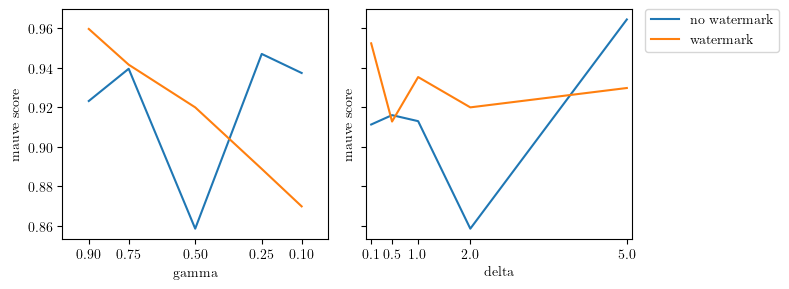

In [21]:
gammas = viz_df["gammas"].values.tolist()
deltas = viz_df["deltas"].values.tolist()

no_watermark_mauve = viz_df["no_watermark_mauve"].values.tolist()
watermark_mauve = viz_df["watermark_mauve"].values.tolist()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3), sharey=True)
slice_idx = len(no_watermark_mauve)//2

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1)
plt.plot(gammas[:slice_idx], no_watermark_mauve[:slice_idx], label="no watermark")
plt.plot(gammas[:slice_idx], watermark_mauve[:slice_idx], label="watermark")
plt.xticks(gammas[:slice_idx])
plt.xlim(0, 1)
# reverse x axis
axs[0].invert_xaxis()
plt.xlabel("gamma")
plt.ylabel("mauve score")

plt.subplot(1, 2, 2)
plt.plot(deltas[slice_idx:], no_watermark_mauve[slice_idx:], label="no watermark")
plt.plot(deltas[slice_idx:], watermark_mauve[slice_idx:], label="watermark")
plt.xticks(deltas[slice_idx:])
plt.xlim(0, 5.1)
plt.xlabel("delta")
plt.ylabel("mauve score")


# legend to right of both charts
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sampling_mauve_score.png")

plt.show()

In [24]:
# Greedy
group_list =(
    (False, 1, 0.1, 0.5),
    (False, 1, 0.5, 0.5),
    (False, 1, 1.0, 0.5),
    (False, 1, 2.0, 0.5),
    (False, 1, 5.0, 0.5),

    (False, 4, 0.1, 0.5),
    (False, 4, 0.5, 0.5),
    (False, 4, 1.0, 0.5),
    (False, 4, 2.0, 0.5),
    (False, 4, 5.0, 0.5),

    (False, 8, 0.1, 0.5),
    (False, 8, 0.5, 0.5),
    (False, 8, 1.0, 0.5),
    (False, 8, 2.0, 0.5),
    (False, 8, 5.0, 0.5),
)

sampling, beams, gammas, deltas = [], [], [], []
# baseline_mauve = []
no_watermark_mauve = []
watermark_mauve = []

for idx, group in enumerate(group_list):
    group_df = grouped_df.get_group(group)

    sampling.append(group[0])
    beams.append(group[1])
    deltas.append(group[2])
    gammas.append(group[3])
    ## get mauve scores
    p_text = group_df["baseline_completion"].values.tolist()
    q_text_w_bl = group_df["w_bl_output"].values.tolist()
    q_text_no_bl = group_df["no_bl_output"].values.tolist()

    watermark_mauve.append(get_mauve_score(p_text, q_text_w_bl, max_len=128))
    no_watermark_mauve.append(get_mauve_score(p_text, q_text_no_bl, max_len=128))

viz_df_greedy = pd.DataFrame()


viz_df_greedy["sampling"] = sampling
viz_df_greedy["beams"] = beams
viz_df_greedy["gammas"] = gammas
viz_df_greedy["deltas"] = deltas

viz_df_greedy['no_watermark_mauve'] = no_watermark_mauve
viz_df_greedy['watermark_mauve'] = watermark_mauve

viz_df_greedy


initial p_text: 497, q_text: 497
remaining p_text: 497, q_text: 497


Featurizing q: 100%|██████████| 497/497 [00:03<00:00, 124.56it/s]
WARNING clustering 994 points to 50 centroids: please provide at least 1950 training points


initial p_text: 497, q_text: 497
remaining p_text: 497, q_text: 497


Featurizing q: 100%|██████████| 497/497 [00:03<00:00, 124.76it/s]
WARNING clustering 994 points to 50 centroids: please provide at least 1950 training points


initial p_text: 496, q_text: 496
remaining p_text: 496, q_text: 496


Featurizing q: 100%|██████████| 496/496 [00:03<00:00, 124.16it/s]
WARNING clustering 992 points to 50 centroids: please provide at least 1950 training points


initial p_text: 496, q_text: 496
remaining p_text: 496, q_text: 496


Featurizing q: 100%|██████████| 496/496 [00:03<00:00, 124.36it/s]
WARNING clustering 992 points to 50 centroids: please provide at least 1950 training points


initial p_text: 497, q_text: 497
remaining p_text: 497, q_text: 497


Featurizing q: 100%|██████████| 497/497 [00:04<00:00, 124.25it/s]
WARNING clustering 994 points to 50 centroids: please provide at least 1950 training points


initial p_text: 497, q_text: 497
remaining p_text: 497, q_text: 497


Featurizing q: 100%|██████████| 497/497 [00:04<00:00, 124.03it/s]
WARNING clustering 994 points to 50 centroids: please provide at least 1950 training points


initial p_text: 495, q_text: 495
remaining p_text: 495, q_text: 495


Featurizing q: 100%|██████████| 495/495 [00:04<00:00, 123.24it/s]
WARNING clustering 990 points to 50 centroids: please provide at least 1950 training points


initial p_text: 495, q_text: 495
remaining p_text: 495, q_text: 495


Featurizing q: 100%|██████████| 495/495 [00:03<00:00, 124.41it/s]
WARNING clustering 990 points to 50 centroids: please provide at least 1950 training points


initial p_text: 495, q_text: 495
remaining p_text: 495, q_text: 495


Featurizing q: 100%|██████████| 495/495 [00:03<00:00, 124.22it/s]
WARNING clustering 990 points to 50 centroids: please provide at least 1950 training points


initial p_text: 495, q_text: 495
remaining p_text: 495, q_text: 495


Featurizing q: 100%|██████████| 495/495 [00:03<00:00, 124.40it/s]
WARNING clustering 990 points to 50 centroids: please provide at least 1950 training points


initial p_text: 500, q_text: 500
remaining p_text: 500, q_text: 500


Featurizing q: 100%|██████████| 500/500 [00:04<00:00, 124.10it/s]
WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points


initial p_text: 500, q_text: 500
remaining p_text: 500, q_text: 500


Featurizing q: 100%|██████████| 500/500 [00:04<00:00, 124.05it/s]
WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 123.97it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 124.27it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 506, q_text: 506
remaining p_text: 506, q_text: 506


Featurizing q: 100%|██████████| 506/506 [00:04<00:00, 124.32it/s]
WARNING clustering 1012 points to 51 centroids: please provide at least 1989 training points


initial p_text: 506, q_text: 506
remaining p_text: 506, q_text: 506


Featurizing q: 100%|██████████| 506/506 [00:04<00:00, 123.82it/s]
WARNING clustering 1012 points to 51 centroids: please provide at least 1989 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 124.06it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 504, q_text: 504
remaining p_text: 504, q_text: 504


Featurizing q: 100%|██████████| 504/504 [00:04<00:00, 124.33it/s]
WARNING clustering 1008 points to 50 centroids: please provide at least 1950 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 124.27it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 507, q_text: 507
remaining p_text: 507, q_text: 507


Featurizing q: 100%|██████████| 507/507 [00:04<00:00, 123.28it/s]
WARNING clustering 1014 points to 51 centroids: please provide at least 1989 training points


initial p_text: 501, q_text: 501
remaining p_text: 501, q_text: 501


Featurizing q: 100%|██████████| 501/501 [00:04<00:00, 122.96it/s]
WARNING clustering 1002 points to 50 centroids: please provide at least 1950 training points


initial p_text: 501, q_text: 501
remaining p_text: 501, q_text: 501


Featurizing q: 100%|██████████| 501/501 [00:04<00:00, 124.21it/s]
WARNING clustering 1002 points to 50 centroids: please provide at least 1950 training points


initial p_text: 503, q_text: 503
remaining p_text: 503, q_text: 503


Featurizing q: 100%|██████████| 503/503 [00:04<00:00, 123.94it/s]
WARNING clustering 1006 points to 50 centroids: please provide at least 1950 training points


initial p_text: 503, q_text: 503
remaining p_text: 503, q_text: 503


Featurizing q: 100%|██████████| 503/503 [00:04<00:00, 124.22it/s]
WARNING clustering 1006 points to 50 centroids: please provide at least 1950 training points


initial p_text: 501, q_text: 501
remaining p_text: 501, q_text: 501


Featurizing q: 100%|██████████| 501/501 [00:04<00:00, 122.84it/s]
WARNING clustering 1002 points to 50 centroids: please provide at least 1950 training points


initial p_text: 501, q_text: 501
remaining p_text: 501, q_text: 501


Featurizing q: 100%|██████████| 501/501 [00:04<00:00, 123.56it/s]
WARNING clustering 1002 points to 50 centroids: please provide at least 1950 training points


initial p_text: 502, q_text: 502
remaining p_text: 502, q_text: 502


Featurizing q: 100%|██████████| 502/502 [00:04<00:00, 124.30it/s]
WARNING clustering 1004 points to 50 centroids: please provide at least 1950 training points


initial p_text: 502, q_text: 502
remaining p_text: 502, q_text: 502


Featurizing q: 100%|██████████| 502/502 [00:04<00:00, 123.62it/s]
WARNING clustering 1004 points to 50 centroids: please provide at least 1950 training points


initial p_text: 498, q_text: 498
remaining p_text: 498, q_text: 498


Featurizing q: 100%|██████████| 498/498 [00:04<00:00, 124.05it/s]
WARNING clustering 996 points to 50 centroids: please provide at least 1950 training points


initial p_text: 498, q_text: 498
remaining p_text: 498, q_text: 498


Featurizing q: 100%|██████████| 498/498 [00:04<00:00, 124.00it/s]
WARNING clustering 996 points to 50 centroids: please provide at least 1950 training points


,sampling,beams,gammas,deltas,no_watermark_mauve,watermark_mauve
0,False,1,0.5,0.1,0.225939,0.232342
1,False,1,0.5,0.5,0.239336,0.221264
2,False,1,0.5,1.0,0.227232,0.260508
3,False,1,0.5,2.0,0.247442,0.263664
4,False,1,0.5,5.0,0.238256,0.188275
5,False,4,0.5,0.1,0.736922,0.798888
6,False,4,0.5,0.5,0.719751,0.675957
7,False,4,0.5,1.0,0.727009,0.652992
8,False,4,0.5,2.0,0.678345,0.674693
9,False,4,0.5,5.0,0.680771,0.675959


03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 14:48:45 - INFO 

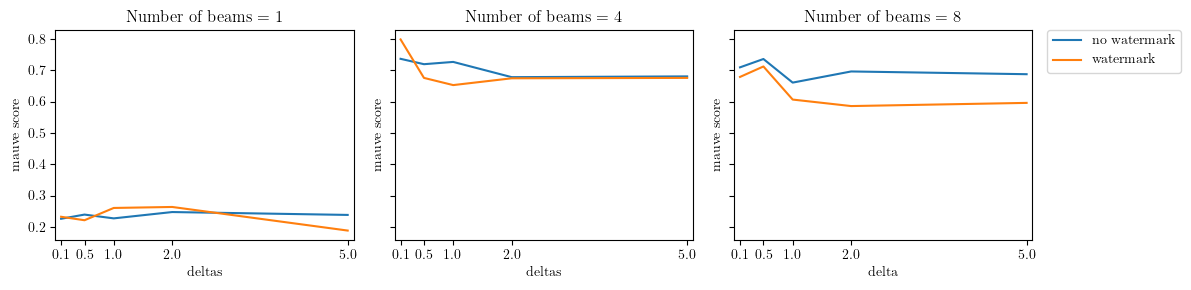

In [26]:
beams = viz_df_greedy["beams"].values.tolist()
deltas = viz_df_greedy["deltas"].values.tolist()

no_watermark_mauve = viz_df_greedy["no_watermark_mauve"].values.tolist()
watermark_mauve = viz_df_greedy["watermark_mauve"].values.tolist() 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
slice_idx = len(no_watermark_mauve)//3

plt.subplot(1, 3, 1)
plt.plot(deltas[:slice_idx], no_watermark_mauve[:slice_idx], label="no watermark")
plt.plot(deltas[:slice_idx], watermark_mauve[:slice_idx], label="watermark")
plt.xticks(deltas[:slice_idx])
plt.xlim(0, 5.1)
plt.title("Number of beams = 1")
plt.xlabel("deltas")
plt.ylabel("mauve score")

plt.subplot(1, 3, 2)
plt.plot(deltas[slice_idx:slice_idx*2], no_watermark_mauve[slice_idx:slice_idx*2], label="no watermark")
plt.plot(deltas[slice_idx:slice_idx*2], watermark_mauve[slice_idx:slice_idx*2], label="watermark")
plt.xticks(deltas[slice_idx:slice_idx*2])
plt.xlim(0, 5.1)
plt.title("Number of beams = 4")
plt.xlabel("deltas")
plt.ylabel("mauve score")

plt.subplot(1, 3, 3)
plt.plot(deltas[slice_idx*2:], no_watermark_mauve[slice_idx*2:], label="no watermark")
plt.plot(deltas[slice_idx*2:], watermark_mauve[slice_idx*2:], label="watermark")
plt.xticks(deltas[slice_idx*2:])
plt.xlim(0, 5.1)
plt.title("Number of beams = 8")
plt.xlabel("delta")
plt.ylabel("mauve score")

# legend to right of both charts
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/beams_mauve_score.png")

plt.show()

In [27]:
# make coherence plot
# Sampling
group_list =(
    (True, 1, 2.0, 0.9),
    (True, 1, 2.0, 0.75),
    (True, 1, 2.0, 0.5),
    (True, 1, 2.0, 0.25),
    (True, 1, 2.0, 0.1),

    (True, 1, 0.1, 0.5),
    (True, 1, 0.5, 0.5),
    (True, 1, 1.0, 0.5),
    (True, 1, 2.0, 0.5),
    (True, 1, 5.0, 0.5),
)

sampling, beams, gammas, deltas = [], [], [], []
baseline_coherence = []
watermark_coherence = []
no_watermark_coherence = []

for idx, group in enumerate(group_list):
    group_df = grouped_df.get_group(group)

    sampling.append(group[0])
    beams.append(group[1])
    deltas.append(group[2])
    gammas.append(group[3])
    ## get coherence scores
    prefix_text = group_df["truncated_input"].values.tolist()

    baseline_completion = group_df["baseline_completion"].values.tolist()
    w_bl_output = group_df["w_bl_output"].values.tolist()
    no_bl_output = group_df["no_bl_output"].values.tolist()

    baseline_coherence.append(get_coherence_score(prefix_text, baseline_completion))
    watermark_coherence.append(get_coherence_score(prefix_text, w_bl_output))
    no_watermark_coherence.append(get_coherence_score(prefix_text, no_bl_output))

viz_df = pd.DataFrame()


viz_df["sampling"] = sampling
viz_df["beams"] = beams
viz_df["gammas"] = gammas
viz_df["deltas"] = deltas

viz_df['baseline_coherence'] = baseline_coherence
viz_df['watermark_coherence'] = watermark_coherence
viz_df['no_watermark_coherence'] = no_watermark_coherence

viz_df

505 505


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


505 505


100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


,sampling,beams,gammas,deltas,baseline_coherence,watermark_coherence,no_watermark_coherence
0,True,1,0.90,2.0,0.614041,0.626746,0.617203
1,True,1,0.75,2.0,0.610991,0.620250,0.618411
2,True,1,0.50,2.0,0.611231,0.607747,0.619677
3,True,1,0.25,2.0,0.607566,0.596032,0.606140
4,True,1,0.10,2.0,0.609115,0.600189,0.609934
5,True,1,0.50,0.1,0.617045,0.612604,0.629051
6,True,1,0.50,0.5,0.620293,0.622709,0.624392
7,True,1,0.50,1.0,0.617551,0.622855,0.623764
8,True,1,0.50,2.0,0.611231,0.607747,0.619677
9,True,1,0.50,5.0,0.616102,0.597489,0.616284


03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:12:46 - INFO 

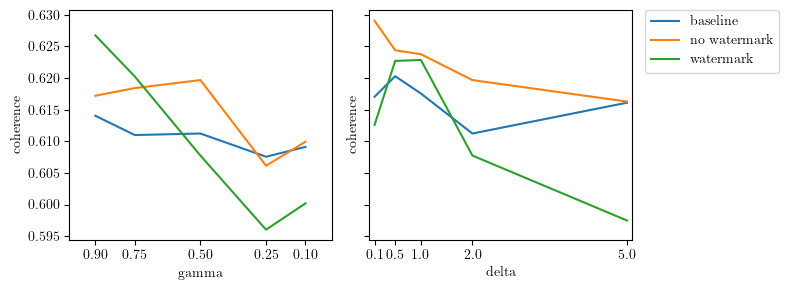

In [31]:
gammas = viz_df["gammas"].values.tolist()
deltas = viz_df["deltas"].values.tolist()

baseline_coherence = viz_df["baseline_coherence"].values.tolist()
watermark_coherence = viz_df["watermark_coherence"].values.tolist()
no_watermark_coherence = viz_df["no_watermark_coherence"].values.tolist()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3), sharey=True)
slice_idx = len(baseline_coherence)//2

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1)
plt.plot(gammas[:slice_idx], baseline_coherence[:slice_idx], label="baseline")
plt.plot(gammas[:slice_idx], no_watermark_coherence[:slice_idx], label="no watermark")
plt.plot(gammas[:slice_idx], watermark_coherence[:slice_idx], label="watermark")
plt.xticks(gammas[:slice_idx])
plt.xlim(0, 1)
# reverse x axis
axs[0].invert_xaxis()
plt.xlabel("gamma")
plt.ylabel("coherence")

plt.subplot(1, 2, 2)
plt.plot(deltas[slice_idx:], baseline_coherence[slice_idx:], label="baseline")
plt.plot(deltas[slice_idx:], no_watermark_coherence[slice_idx:], label="no watermark")
plt.plot(deltas[slice_idx:], watermark_coherence[slice_idx:], label="watermark")
plt.xticks(deltas[slice_idx:])
plt.xlim(0, 5.1)
plt.xlabel("delta")
plt.ylabel("coherence")


# legend to right of both charts
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sampling_coherence_score.png")

plt.show()

In [29]:
# Greedy
group_list =(
    (False, 1, 0.1, 0.5),
    (False, 1, 0.5, 0.5),
    (False, 1, 1.0, 0.5),
    (False, 1, 2.0, 0.5),
    (False, 1, 5.0, 0.5),

    (False, 4, 0.1, 0.5),
    (False, 4, 0.5, 0.5),
    (False, 4, 1.0, 0.5),
    (False, 4, 2.0, 0.5),
    (False, 4, 5.0, 0.5),

    (False, 8, 0.1, 0.5),
    (False, 8, 0.5, 0.5),
    (False, 8, 1.0, 0.5),
    (False, 8, 2.0, 0.5),
    (False, 8, 5.0, 0.5),
)

sampling, beams, gammas, deltas = [], [], [], []
baseline_coherence = []
watermark_coherence = []
no_watermark_coherence = []

for idx, group in enumerate(group_list):
    group_df = grouped_df.get_group(group)

    sampling.append(group[0])
    beams.append(group[1])
    deltas.append(group[2])
    gammas.append(group[3])
    ## get coherence scores
    prefix_text = group_df["truncated_input"].values.tolist()

    baseline_completion = group_df["baseline_completion"].values.tolist()
    w_bl_output = group_df["w_bl_output"].values.tolist()
    no_bl_output = group_df["no_bl_output"].values.tolist()

    baseline_coherence.append(get_coherence_score(prefix_text, baseline_completion))
    watermark_coherence.append(get_coherence_score(prefix_text, w_bl_output))
    no_watermark_coherence.append(get_coherence_score(prefix_text, no_bl_output))

viz_df_greedy = pd.DataFrame()


viz_df_greedy["sampling"] = sampling
viz_df_greedy["beams"] = beams
viz_df_greedy["gammas"] = gammas
viz_df_greedy["deltas"] = deltas

viz_df_greedy['baseline_coherence'] = baseline_coherence
viz_df_greedy['watermark_coherence'] = watermark_coherence
viz_df_greedy['no_watermark_coherence'] = no_watermark_coherence

viz_df_greedy



497 497


100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


497 497


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


497 497


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


496 496


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


496 496


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


496 496


100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


497 497


100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


497 497


100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


497 497


100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


495 495


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


500 500


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


500 500


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


500 500


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


506 506


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


504 504


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


507 507


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


503 503


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


501 501


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


502 502


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


502 502


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


502 502


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


498 498


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


498 498


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


498 498


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


,sampling,beams,gammas,deltas,baseline_coherence,watermark_coherence,no_watermark_coherence
0,False,1,0.5,0.1,0.614911,0.557207,0.565086
1,False,1,0.5,0.5,0.613323,0.572616,0.566163
2,False,1,0.5,1.0,0.613967,0.568145,0.561886
3,False,1,0.5,2.0,0.613299,0.564281,0.563407
4,False,1,0.5,5.0,0.616185,0.551181,0.566810
5,False,4,0.5,0.1,0.613063,0.592225,0.591852
6,False,4,0.5,0.5,0.610608,0.584787,0.587506
7,False,4,0.5,1.0,0.608079,0.581858,0.579531
8,False,4,0.5,2.0,0.611976,0.572840,0.586869
9,False,4,0.5,5.0,0.612457,0.542646,0.588146


03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO - matplotlib.texmanager -   No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
03/31/2023 15:34:14 - INFO 

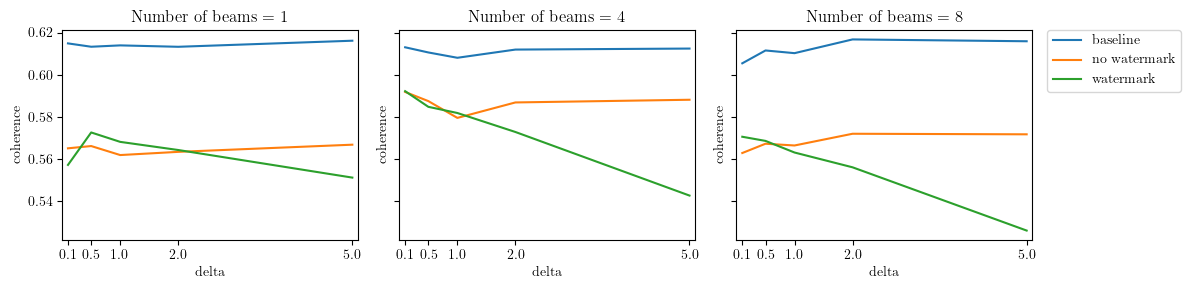

In [33]:
gammas = viz_df_greedy["gammas"].values.tolist()
deltas = viz_df_greedy["deltas"].values.tolist()

baseline_coherence = viz_df_greedy["baseline_coherence"].values.tolist()
watermark_coherence = viz_df_greedy["watermark_coherence"].values.tolist()
no_watermark_coherence = viz_df_greedy["no_watermark_coherence"].values.tolist()

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
slice_idx = len(baseline_coherence)//3


plt.subplot(1, 3, 1)
plt.plot(deltas[:slice_idx], baseline_coherence[:slice_idx], label="baseline")
plt.plot(deltas[:slice_idx], no_watermark_coherence[:slice_idx], label="no watermark")
plt.plot(deltas[:slice_idx], watermark_coherence[:slice_idx], label="watermark")
plt.xticks(deltas[:slice_idx])
plt.xlim(0, 5.1)
# reverse x axis
# axs[0].invert_xaxis()
plt.title("Number of beams = 1")
plt.xlabel("delta")
plt.ylabel("coherence")

plt.subplot(1, 3, 2)
plt.plot(deltas[slice_idx:slice_idx*2], baseline_coherence[slice_idx:slice_idx*2], label="baseline")
plt.plot(deltas[slice_idx:slice_idx*2], no_watermark_coherence[slice_idx:slice_idx*2], label="no watermark")
plt.plot(deltas[slice_idx:slice_idx*2], watermark_coherence[slice_idx:slice_idx*2], label="watermark")
plt.xticks(deltas[slice_idx:slice_idx*2])
plt.xlim(0, 5.1)
plt.title("Number of beams = 4")
plt.xlabel("delta")
plt.ylabel("coherence")

plt.subplot(1, 3, 3)
plt.plot(deltas[slice_idx*2:], baseline_coherence[slice_idx*2:], label="baseline")
plt.plot(deltas[slice_idx*2:], no_watermark_coherence[slice_idx*2:], label="no watermark")
plt.plot(deltas[slice_idx*2:], watermark_coherence[slice_idx*2:], label="watermark")
plt.xticks(deltas[slice_idx*2:])
plt.xlim(0, 5.1)
plt.title("Number of beams = 8")
plt.xlabel("delta")
plt.ylabel("coherence")


# legend to right of both charts
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/beams_coherence_score.png")

plt.show()